In [26]:
import polars as pl
import matplotlib.pyplot as plt

In [8]:
# Read in the CSV files
gis_df = pl.read_csv("../data/gis.csv")
data_df = pl.read_csv("../data/data.csv", ignore_errors=True)

# Perform left join from gis to data and add assessed column
df = gis_df.join(
    data_df,
    left_on="ADM3_CODE",  # column from gis.csv
    right_on="m0305_meta_adm3_pcode",  # column from data.csv
    how='left'
).with_columns([
    pl.when(pl.col("_uuid").is_null())
      .then(pl.lit("no"))
      .otherwise(pl.lit("yes"))
      .alias('assessed'),
    # Add movement type columns with default 'no'
    pl.lit("no").alias('arrivals'),
    pl.lit("no").alias('departures'),
    pl.lit("no").alias('returnees')
]).with_columns([
    # Set movement types to 'yes' based on _uuid presence and type
    pl.when((pl.col("_uuid").is_not_null()) & 
            (pl.col("m1536_loc_num_arrival_ind_period") > 0))
      .then(pl.lit("yes"))
      .otherwise(pl.col("arrivals"))
      .alias('arrivals'),
    pl.when((pl.col("_uuid").is_not_null()) & 
            (pl.col("m1540_loc_num_depart_ind_period") > 0))
      .then(pl.lit("yes"))
      .otherwise(pl.col("departures"))
      .alias('departures'),
    pl.when((pl.col("_uuid").is_not_null()) & 
            (pl.col("m0851_loc_num_return_idp_ind") > 0))
      .then(pl.lit("yes"))
      .otherwise(pl.col("returnees"))
      .alias('returnees')
])

# Print the column names and first few rows to verify
print("Available columns:", df.columns)
print("\nSample of movement type columns:")
print(df.select(['assessed', 'arrivals', 'departures', 'returnees']).head())

Available columns: ['OBJECTID', 'COUNTRY', 'ISO3', 'ISO2', 'ADM1_NAME', 'ADM1_CODE', 'ADM1_ID', 'ADM1_Type', 'ADM2_NAME', 'ADM2_CODE', 'ADM2_ID', 'ADM2_Type', 'ADM3_NAME', 'ADM3_CODE', 'ADM3_ID', 'ADM3_Type', 'Latitude', 'Longitude', 'm2682_meta_date_auto', 'm1855_meta_assessment_date', 'm1725_meta_interview_type', 'm0489_meta_survey_round', 'calc_adm2_local', 'm0303_meta_adm1_pcode', 'm0304_meta_adm2_pcode', 'm0306_meta_adm4_pcode_other', 'm0306_meta_adm4_pcode', 'admin_4_name_txt_calc', 's1534_loc_loc_access', 'm0342_loc_site_type_multiple', 'm0342_loc_site_type_multiple_other', 'm1690_loc_depart_hh', 'm1541_loc_num_depart_hh_period', 'm1540_loc_num_depart_ind_period', 'm0349_loc_depart_period', 'm2990_loc_depart_internal', 'm2991_loc_depart_known', 'm1577_loc_main_dest_adm1', 'm1584_loc_main_depart_reason', 'm1584_loc_main_depart_reason_other', 'm1535_loc_arrival_time', 'm1537_loc_num_arrivals_hh', 'm1536_loc_num_arrival_ind_period', 'm2968_loc_num_men_idp', 'm2969_loc_num_women_idp

In [10]:
df=df.to_pandas()

In [11]:
df

,OBJECTID,COUNTRY,ISO3,ISO2,ADM1_NAME,ADM1_CODE,ADM1_ID,ADM1_Type,ADM2_NAME,ADM2_CODE,...,_notes,_status,_submitted_by,__version__,_tags,_index,assessed,arrivals,departures,returnees
0,184585,Malawi,MWI,MW,Northern,MW1,1,Region,Chitipa,MW101,...,None,None,None,None,None,NaN,no,no,no,no
1,184586,Malawi,MWI,MW,Northern,MW1,1,Region,Chitipa,MW101,...,None,None,None,None,None,NaN,no,no,no,no
2,184587,Malawi,MWI,MW,Northern,MW1,1,Region,Chitipa,MW101,...,None,None,None,None,None,NaN,no,no,no,no
3,184588,Malawi,MWI,MW,Northern,MW1,1,Region,Chitipa,MW101,...,None,None,None,None,None,NaN,no,no,no,no
4,184589,Malawi,MWI,MW,Northern,MW1,1,Region,Chitipa,MW101,...,None,None,None,None,None,NaN,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,185013,Malawi,MWI,MW,Southern,MW3,3,Region,Blantyre City,MW315,...,None,None,None,None,None,NaN,no,no,no,no
1127,185014,Malawi,MWI,MW,Southern,MW3,3,Region,Blantyre City,MW315,...,None,None,None,None,None,NaN,no,no,no,no
1128,185015,Malawi,MWI,MW,Southern,MW3,3,Region,Blantyre City,MW315,...,None,None,None,None,None,NaN,no,no,no,no
1129,185016,Malawi,MWI,MW,Southern,MW3,3,Region,Blantyre City,MW315,...,None,None,None,None,None,NaN,no,no,no,no


In [82]:
import geopandas as gpd
from shapely.geometry import Point

# Create geometry from latitude and longitude
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=geometry,
    crs="EPSG:4326"
)

In [83]:
gdf


,OBJECTID,COUNTRY,ISO3,ISO2,ADM1_NAME,ADM1_CODE,ADM1_ID,ADM1_Type,ADM2_NAME,ADM2_CODE,ADM2_ID,ADM2_Type,ADM3_NAME,ADM3_CODE,ADM3_ID,ADM3_Type,Latitude,Longitude,m2682_meta_date_auto,m1855_meta_assessment_date,m1725_meta_interview_type,m0489_meta_survey_round,calc_adm2_local,m0303_meta_adm1_pcode,m0304_meta_adm2_pcode,m0306_meta_adm4_pcode_other,m0306_meta_adm4_pcode,admin_4_name_txt_calc,s1534_loc_loc_access,m0342_loc_site_type_multiple,m0342_loc_site_type_multiple_other,m1690_loc_depart_hh,m1541_loc_num_depart_hh_period,m1540_loc_num_depart_ind_period,m0349_loc_depart_period,m2990_loc_depart_internal,m2991_loc_depart_known,m1577_loc_main_dest_adm1,m1584_loc_main_depart_reason,m1584_loc_main_depart_reason_other,...,m2694_loc_top_3_priority_need_returnee/information,m2694_loc_top_3_priority_need_returnee/electricity,m2694_loc_top_3_priority_need_returnee/language,m2694_loc_top_3_priority_need_returnee/medicines,m2694_loc_top_3_priority_need_returnee/none,m2694_loc_top_3_priority_need_returnee/nfi,m2694_loc_top_3_priority_need_returnee/other,m2694_loc_top_3_priority_need_returnee/hygiene,m2694_loc_top_3_priority_need_returnee/pnta,m2694_loc_top_3_priority_need_returnee/protection,m2694_loc_top_3_priority_need_returnee/reporting,m2694_loc_top_3_priority_need_returnee/pss,m2694_loc_top_3_priority_need_returnee/school_supplies,m2694_loc_top_3_priority_need_returnee/security,m2694_loc_top_3_priority_need_returnee/child_spaces,m2694_loc_top_3_priority_need_returnee/return_support,m2694_loc_top_3_priority_need_returnee/business,m2694_loc_top_3_priority_need_returnee/vocational,m2694_loc_top_3_priority_need_returnee/wash,m2694_loc_top_3_priority_need_returnee/agricultural_inputs,m2694_loc_top_3_priority_need_returnee_other,m2695_loc_returnees_settle_adm4_other,m2695_loc_returnees_settle_adm4,m2695_loc_returnees_settle_adm4_zwe,remarks,_id,_uuid,_submission_time,_validation_status,_notes,_status,_submitted_by,__version__,_tags,_index,assessed,arrivals,departures,returnees,geometry
0,184585,Malawi,MWI,MW,Northern,MW1,1,Region,Chitipa,MW101,1,District,TA Mwabulambya,MW10101,1,Traditional Area,-9.759365,33.372102,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,NaN,NaN,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,no,no,no,no,POINT (33.3721 -9.75936)
1,184586,Malawi,MWI,MW,Northern,MW1,1,Region,Chitipa,MW101,1,District,STA Bulambya Songwe,MW10102,2,Traditional Area,-9.563646,33.290993,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,NaN,NaN,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,no,no,no,no,POINT (33.29099 -9.56365)
2,184587,Malawi,MWI,MW,Northern,MW1,1,Region,Chitipa,MW101,1,District,TA Mwenemisuku,MW10103,3,Traditional Area,-9.745508,33.535586,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,NaN,NaN,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,no,no,no,no,POINT (33.53559 -9.74551)
3,184588,Malawi,MWI,MW,Northern,MW1,1,Region,Chitipa,MW101,1,District,STA Lwangwa,MW10104,4,Traditional Area,-9.662173,33.612700,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,NaN,NaN,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,no,no,no,no,POINT (33.6127 -9.66217)
4,184589,Malawi,MWI,MW,Northern,MW1,1,Region,Chitipa,MW101,1,District,TA Mwenewenya,MW10105,5,Traditional Area,-10.058799,33.480848,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,NaN,NaN,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN

In [88]:
import contextily as ctx
import matplotlib.pyplot as plt

# Convert GeoDataFrame to Web Mercator for basemap
gdf_web = gdf.to_crs(epsg=3857)

# Function to create a map
def create_map(movement_type, color, title, filename):
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot locations with movement type
    locations = gdf_web[gdf_web[movement_type] == "yes"]
    locations.plot(ax=ax, color=color, alpha=0.6, markersize=50)
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution=None, attribution_size=0)
    
    # Customize plot
    ax.set_axis_off()
    ax.set_aspect('equal')
    # ax.legend([title], loc='upper right')
    
    # Save and close
    plt.tight_layout()
    plt.savefig(f'../figures/{filename}.svg', format='svg', bbox_inches='tight', dpi=300)
    plt.close()

# Create three separate maps
create_map('arrivals', '#F09362', 'Locations with Arrivals', 'fig-map-locations-arrivals')
create_map('departures', '#F7CC69', 'Locations with Departures', 'fig-map-locations-departures')
create_map('returnees', '#94C8C4', 'Returns', 'fig-map-locations-returns')

In [ ]:
# Verify our data
print("Column names:", gdf.columns.tolist())
print("\nSample of movement columns:")
print(gdf[['assessed', 'arrivals', 'departures', 'returnees']].head())

In [ ]:
from upsetplot import generate_counts
example = generate_counts()
example

cat0   cat1   cat2 
False  False  False      56
              True      283
       True   False    1279
              True     5882
True   False  False      24
              True       90
       True   False     429
              True     1957
Name: value, dtype: int64

/Users/brian/Code/malawi/.pixi/envs/default/lib/python3.13/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/brian/Code/malawi/.pixi/envs/default/lib/python3.13/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

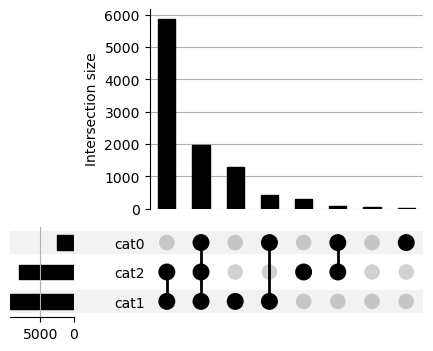

In [3]:
from upsetplot import plot
plot(example, sort_by='cardinality')  
from matplotlib import pyplot
pyplot.show()

In [12]:
df.columns.to_list()

['OBJECTID',
 'COUNTRY',
 'ISO3',
 'ISO2',
 'ADM1_NAME',
 'ADM1_CODE',
 'ADM1_ID',
 'ADM1_Type',
 'ADM2_NAME',
 'ADM2_CODE',
 'ADM2_ID',
 'ADM2_Type',
 'ADM3_NAME',
 'ADM3_CODE',
 'ADM3_ID',
 'ADM3_Type',
 'Latitude',
 'Longitude',
 'm2682_meta_date_auto',
 'm1855_meta_assessment_date',
 'm1725_meta_interview_type',
 'm0489_meta_survey_round',
 'calc_adm2_local',
 'm0303_meta_adm1_pcode',
 'm0304_meta_adm2_pcode',
 'm0306_meta_adm4_pcode_other',
 'm0306_meta_adm4_pcode',
 'admin_4_name_txt_calc',
 's1534_loc_loc_access',
 'm0342_loc_site_type_multiple',
 'm0342_loc_site_type_multiple_other',
 'm1690_loc_depart_hh',
 'm1541_loc_num_depart_hh_period',
 'm1540_loc_num_depart_ind_period',
 'm0349_loc_depart_period',
 'm2990_loc_depart_internal',
 'm2991_loc_depart_known',
 'm1577_loc_main_dest_adm1',
 'm1584_loc_main_depart_reason',
 'm1584_loc_main_depart_reason_other',
 'm1535_loc_arrival_time',
 'm1537_loc_num_arrivals_hh',
 'm1536_loc_num_arrival_ind_period',
 'm2968_loc_num_men_idp',


In [21]:
# Filter df to only include assessed rows
df_assessed = df[df['assessed'] == 'yes']

In [22]:
df_temp = df_assessed [['arrivals',
 'departures',
 'returnees']]

In [24]:
# Create binary indicators for each movement type
movement_types = ['arrivals', 'departures', 'returnees']
df_indicators = df_temp.copy()

# Convert yes/no to boolean True/False
for col in movement_types:
    df_indicators[col] = df_indicators[col] == 'yes'

# Create a list of tuples for all combinations
combinations = df_indicators.groupby(movement_types).size()

print("Movement type combinations and their frequencies:")
print(combinations)

Movement type combinations and their frequencies:
arrivals  departures  returnees
False     False       False        150
                      True          51
          True        False         71
                      True          60
True      False       False        139
                      True          48
          True        False        103
                      True         154
dtype: int64


/Users/brian/Code/malawi/.pixi/envs/default/lib/python3.13/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/brian/Code/malawi/.pixi/envs/default/lib/python3.13/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

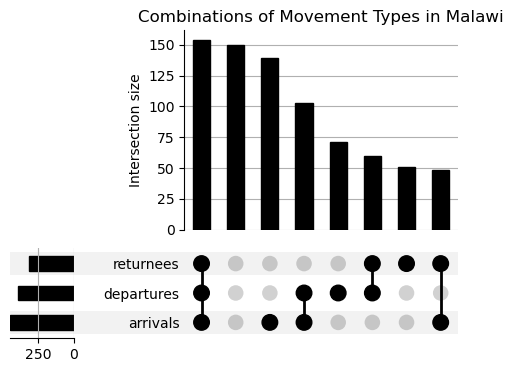

In [ ]:
from upsetplot import plot
from matplotlib import pyplot

# Create and customize the upset plot
plot(combinations, sort_by='cardinality')

# Customize the plot
plt.title('Assessed locations with population types')

# Show the plot
pyplot.show()

# Save the plot
#plt.savefig('../figures/fig-upset-movement-types.svg', format='svg', bbox_inches='tight', dpi=300)
plt.close()

In [20]:
len(df)

1131

In [ ]:
# Create a list of all combinations and count occurrences
import pandas as pd
import numpy as np

# Convert movement type columns to boolean
movement_types = ['arrivals', 'departures', 'returnees']
bool_df = df_temp.apply(lambda x: x == 'yes')

# Create MultiIndex Series with counts
index = pd.MultiIndex.from_tuples(
    [(a, d, r) for a in [False, True] 
              for d in [False, True] 
              for r in [False, True]],
    names=movement_types
)

# Count occurrences of each combination
counts = pd.Series(0, index=index, dtype=int)
for _, row in bool_df.iterrows():
    key = tuple(row)
    if key in counts.index:
        counts[key] += 1

# Print the first few counts to verify
print("Movement type combinations and their counts:")
print(counts[counts > 0].sort_values(ascending=False))

In [ ]:
# Create a copy and convert yes/no to boolean values
df_upset = df_temp.copy()
df_upset = df_upset.apply(lambda x: x == 'yes')
df_upset

In [28]:
import upsetplot

# Create the upset plot
upset = upsetplot.UpSet(
    df_upset,
    subset_size='count',
    min_subset_size=1,
    show_counts=True
)

# Create figure with specific size
plt.figure(figsize=(12, 8))

# Generate and customize the plot
upset.plot()

# Add y-axis label
plt.ylabel('Number of assessed locations')

# Save the plot
plt.savefig('../figures/fig-upset-movement-types.svg', bbox_inches='tight', dpi=300)
plt.close()

AttributeError: 'RangeIndex' object has no attribute 'levels'